# **Classification** des **séries temporelles** avec `sktime`

## Métadonnées

- **Expérience nº :** 2
- **Date :** 05/11/2023
- **Heure :** 13:31
- **Données :** `ready_Evaporation.csv`
- **Splitter :** `TimeSeriesSplit`
- **Méthode :** TSF

## Sommaire

1. Initialisation
2. Découpage des données
3. Conversion des données
4. Modélisation
5. Évaluation

## 1. Initialisation

In [3]:
# Importation des bibliothèques et modules nécessaires au fonctionnement de ce notebook

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style = "darkgrid", palette = "colorblind")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler, SMOTE
from joblib import dump, load # pour enregistrer et charger les modèles.
n_coeurs = 4

In [38]:
# Importation du jeu de données et enregistrement dans le DataFrame `df`

# Instanciation df 
df = pd.read_csv('../../data/processed/model_weatherAUS.csv', index_col = 1).sort_index()
df.drop(columns = 'Unnamed: 0', inplace = True)

In [39]:
# Inspection de la structure de `df`

df.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Month,Day,LocationNum,WindGustDirNum,WindDir9amNum,WindDir3pmNum,Latitude,Longitude,CodeRegionNum,NonMesNum
Date,,,,,,,,,,,,,,,,,,,,,
2007-11-01,8.0,24.3,0.0,3.4,6.3,30.0,6.0,20.0,68.0,29.0,...,11,1,15,2.356194,3.926991,2.356194,-35.297591,149.101268,1,2
2007-11-02,14.0,26.9,3.6,4.4,9.7,39.0,4.0,17.0,80.0,36.0,...,11,2,15,0.392699,0.000000,3.141593,-35.297591,149.101268,1,2
2007-11-03,13.7,23.4,3.6,5.8,3.3,85.0,6.0,6.0,82.0,69.0,...,11,3,15,2.356194,1.570796,1.178097,-35.297591,149.101268,1,2
2007-11-04,13.3,15.5,39.8,7.2,9.1,54.0,30.0,24.0,62.0,56.0,...,11,4,15,2.356194,2.748894,3.141593,-35.297591,149.101268,1,2
2007-11-05,7.6,16.1,2.8,5.6,10.6,50.0,20.0,28.0,68.0,49.0,...,11,5,15,5.105088,5.105088,5.890486,-35.297591,149.101268,1,2


## 2. Découpage des données

In [40]:
# Découpage de `df` sur l'axe des colonnes : séparation des variables explicatives (`data`) et cible (`target`)

data = df.drop(columns = "RainTomorrow")
target = df["RainTomorrow"]

In [41]:
# Découpage de `data` et de `target` sur l'axe des lignes : séparation des jeux d'entraînement (`*_train`) et de test (`*_test`) avec le splitter `TimeSeriesSplit`

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5) ## Nous fixons le paramètre `n_splits` à 5 afin d'avoir une répartition de 80 / 20 entre les jeux d'entraînement et de test, respectivement.

for train_index, test_index in tss.split(data):
    X_train, X_test = data.iloc[train_index, :], data.iloc[test_index,:]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]



In [ ]:
# Oversample avec SMOTE
#smote = SMOTE(random_state = 12, n_jobs = n_coeurs)
#X_sm, y_sm = smote.fit_resample(X_train, y_train)

## 3. Conversion des données

In [37]:
X_train.shape

(117323, 28)

In [42]:
# Scale de X_train, X_test:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
X_train.shape

(117323, 28)

In [45]:
# Récupération des dimensions

X_train_d1, X_train_d2 = X_train.shape
X_test_d1, X_test_d2 = X_test.shape

# Conversion des DataFrames `X` en arrays de 3 dimensions

X_train_np = X_train.reshape(X_train_d1, X_train_d2, 1)
X_test_np = X_test.reshape(X_test_d1, X_test_d2, 1)

# Conversion des Series `y` en arrays de 1 dimension

y_train_np = y_train.to_numpy()
y_test_np = y_test.to_numpy()

## 4. Modélisation

La méthode TSF (_time series forest_) appartient à la famille des approches de classification des séries temporelles basées sur les **intervalles** (_interval-based approaches_).

Il s'agit d'une adaptation aux séries temporelles de l'algorithme _random forest classifier_ (RCF).

La TSF utilise un arbre de décision pour chaque intervalle, les arbres de décision agrégés constituant la forêt. Chaque arbre de décision est un modèle d'apprentissage automatique qui attribue ensuite une classe à son intervalle de données. Étant donné que les arbres de décision s'entraînent sur un intervalle différent de la série temporelle globale, ils peuvent ne pas produire la même classification, d'où la nécessité du vote d'ensemble à la fin du processus.

Des études expérimentales ont démontré que la TSF est capable de produire de meilleurs résultats que la KNN + DTW.

Références :
1. https://developer.ibm.com/learningpaths/get-started-time-series-classification-api/what-is-time-series-classification
2. https://towardsdatascience.com/a-brief-introduction-to-time-series-classification-algorithms-7b4284d31b97
3. https://arxiv.org/abs/1602.01711

In [46]:
# Instanciation d'un modèle classificateur via un Pipeline

from sklearn.pipeline import Pipeline
from sktime.transformations.panel.compose import ColumnConcatenator
from sktime.classification.interval_based import TimeSeriesForestClassifier

steps = [
    ("concatenate", ColumnConcatenator()), ## Cette étape permet de transformer les jeux de données multivariées en univariées afin qu'ils puissent être traités par `TimeSeriesForestClassifier`.
    ("classify", TimeSeriesForestClassifier()),
]

clf_rf_ts = Pipeline(steps)

In [10]:
# Récupération des paramètres initiaux de la TSF

clf_rf_ts["classify"].get_params()

{'inner_series_length': None,
 'min_interval': 3,
 'n_estimators': 200,
 'n_jobs': 1,
 'random_state': None}

In [48]:
# Entraînement du modèle
clf_rf_ts.fit(X_train_np, y_train_np)

Pipeline(steps=[('concatenate', ColumnConcatenator()),
                ('classify', TimeSeriesForestClassifier())])

In [49]:
dump(clf_rf_ts, 'saves/model_saves/save_TSF_Alex_scale.joblib')

['saves/model_saves/save_TSF_Alex_scale.joblib']

In [50]:
# Récupération des paramètres ajustés de la TSF

clf_rf_ts["classify"].get_fitted_params()

{'classes': array([0, 1], dtype=int64),
 'intervals': [array([[20, 23],
         [ 7, 15],
         [10, 20],
         [16, 26],
         [ 8, 12]]),
  array([[11, 24],
         [ 6, 12],
         [17, 20],
         [17, 26],
         [11, 21]]),
  array([[19, 24],
         [ 8, 13],
         [ 8, 15],
         [ 0,  3],
         [20, 23]]),
  array([[11, 15],
         [19, 22],
         [24, 27],
         [17, 20],
         [14, 17]]),
  array([[ 1,  4],
         [18, 21],
         [ 4, 17],
         [ 3, 13],
         [ 0,  3]]),
  array([[18, 24],
         [11, 16],
         [17, 20],
         [11, 26],
         [23, 26]]),
  array([[11, 19],
         [18, 21],
         [20, 23],
         [ 2, 23],
         [12, 15]]),
  array([[21, 26],
         [ 4, 15],
         [11, 24],
         [ 3, 13],
         [20, 23]]),
  array([[ 1,  4],
         [10, 13],
         [17, 26],
         [21, 24],
         [ 1,  4]]),
  array([[14, 25],
         [ 7, 14],
         [ 2, 11],
         [ 2, 20]

In [52]:
X_test.shape

(23464, 28)

In [53]:
# Réalisation des prédictions
clf_rf_ts = load('saves/model_saves/save_TSF_Alex_scale.joblib')
y_pred = clf_rf_ts.predict(X_test_np)

## 5. Évaluation

In [54]:
# Élaboration de la matrice de confusion

pd.crosstab(y_test, y_pred, rownames = ["Classe réelle"], colnames = ["Classe prédite"])

Classe prédite,0,1
Classe réelle,,
0,17613,506
1,3688,1657


In [55]:
# Élaboration du rapport de classification

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.97      0.89     18119
           1       0.77      0.31      0.44      5345

    accuracy                           0.82     23464
   macro avg       0.80      0.64      0.67     23464
weighted avg       0.81      0.82      0.79     23464



# 6. Roc

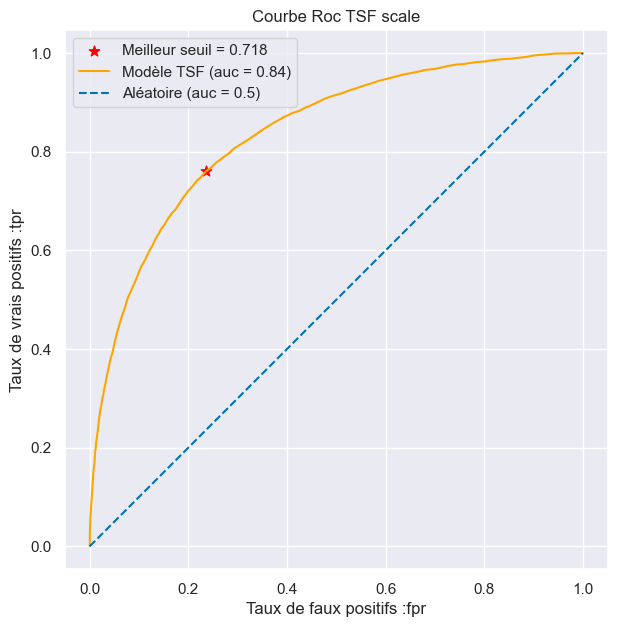

Report TSF scale 
               precision    recall  f1-score   support

           0       0.78      1.00      0.88     18119
           1       0.92      0.07      0.12      5345

    accuracy                           0.79     23464
   macro avg       0.85      0.53      0.50     23464
weighted avg       0.81      0.79      0.71     23464

[[18088    31]
 [ 4993   352]]


In [56]:
clf_rf_ts = load('saves/model_saves/save_TSF_Alex_scale.joblib')
# On fait la prediction sur test:
preds = clf_rf_ts.predict_proba(X_test_np)

################################ On cherche le meilleur seuil:
# Création des arrays fpr, tpr et seuils:
fpr, tpr, seuils = roc_curve(y_test, preds[:, 1], pos_label = 1) # on choisit pred[:, 1] pour prendre parmi les deux probas celle qui correspond à la classe positive.

# Pour calculer l'aire sous la courbe ROC:
roc_auc = auc(x = fpr, y = tpr)

# Comment trouver le meilleur seuil?
dist = 1
for (x, y, s) in zip(fpr, tpr, seuils):
    dist1 = np.square(x**2 + (y-1)**2) 
    if dist1 < dist:
        dist = dist1
        seuil_best = 1 - s # pourquoi dois-je faire ça?
        fpr_best = x
        tpr_best = y
        
#print("Meilleur seuil:", seuil_best, "meilleur fpr:", fpr_best, "meilleur tpr:", tpr_best)

# Tracé de ROC:
plt.figure(figsize = (7, 7))
plt.axis('equal')

plt.scatter(fpr_best, tpr_best, s = 60, c = 'red', marker = '*', alpha = 1, label = "Meilleur seuil = %0.3f" % seuil_best)
plt.plot(fpr, tpr, c = 'orange', label = 'Modèle TSF (auc = %0.2f)' % roc_auc)
plt.plot(fpr, fpr, 'b--', label = 'Aléatoire (auc = 0.5)')

plt.title('Courbe Roc TSF scale')
plt.xlabel('Taux de faux positifs :fpr')
plt.ylabel('Taux de vrais positifs :tpr')
plt.legend()

plt.show()

################### On applique le meilleur seuil:
y_pred = pd.Series(np.where(preds[:, 1] > seuil_best, 1, 0))

print("Report TSF scale", "\n", classification_report(y_test, y_pred,  digits = 2))
print(confusion_matrix(y_test, y_pred))

Bilan: faut pas faire d'opti roc sur ce modèle non plus! :)